# Get Started

F4Enix allows you to parse and manipulate a number of files that are commonly found in any neutronics pre and post-processing pipeline. Detailing the full capabilities of the package can be quite a long process. Luckily, extensive usage examples that are classified by type of file being processed can be found in the :doc:`/examples/examples_idx` or  :doc:`../examples/examples_idx`. The scope of this quick tutorial instead is to give a first feeling of what F4Enix can do and how it could be integrated in your workflow.

```{eval-rst}
The complete API can be found at :doc:`/examples/examples_idx` or :doc:`../examples/examples_idx`
```

If you did not install ``f4enix`` yet, please refer to the [installation instructions](/../usage/installation.html).

## Pre-process an MCNP input

For the purpose of this example, let's imagine to have a simple model that includes only a sphere. Here is a bit of code reading the MCNP input and prints the cells and surfaces lines of such input.

In [28]:
from f4enix import Input

inp = Input.from_input('Sphere.i')
# this is a print trick to get a preview of a specific section of the input
print("".join(inp._print_cards(inp.cells)))

print("".join(inp._print_cards(inp.surfs)))

1  0          -1    IMP:N=1   IMP:P=1
2  1 -0.302  +1 -2     IMP:N=1   IMP:P=1
3  0          +2    IMP:N=0   IMP:P=0

1 S 0 0 0 5
2 S 0 0 0 50
3 S 0 0 0 60



Now let's imagine that for some reason we want the cell 2 to become an envelope because we want to fill it with a more complex geometry (filler). Let us suppose also that such filler has been already generated and it is available as another mcnp input file.

### Dealing with universes

Let's start by exploring the filler, which in this case it will be simply a sphere but could be arbitrary complex

In [29]:
# load the filler to be used lately
filler = Input.from_input('filler.i')

# simply read the text file
with open ('filler.i') as infile:
    contents = infile.read()
    print(contents)

FILLER INPUT
1  1 -0.302  -1   IMP:N=1   IMP:P=1

1 S 0 0 0 55

C
M1    1001.31c 1
      1002.31c 2



Clearly a renumbering of the cells and surfaces will be needed before adding it to the main input. Moreover, the universe card should be added. We can also check for available cell ranges in the main input. It may be trivial here, but it could be quite useful for more complex models

In [30]:
# check the ID range between 10 and 19
print(inp.check_range(range(10, 20), "cell"))
print(inp.check_range(range(10, 20), "surf"))

True
True


In [31]:
universe_number = 1
filler.add_cell_fill_u(filler.cells["1"], "u", universe_number)  # add a cell to a universe
filler.renumber(renum_all=10, update_keys=True)  # cells, surfaces, universes, etc. can be renumbered

Now that the filler is all set, we can create the envelope into the main input and add all the cells from the filler.

The cell of interest needs first to be identify, set to void and provided with a fill card. Then the filler can be merged into the main input.

In [32]:
# The easiest way to get the cell would be
# cell = inp.cells["2"]
# let's imagine we do not know exactly the cell id but we now that everything that
# has a certain material needs to be set to envelope
for key, cell in inp.cells.items():
    if cell.get_m() == 1:
        # prepare the envelope
        inp.set_cell_void(cell)  # remove the material from the cell
        inp.add_cell_fill_u(cell, 'fill', 11)  # add a fill card

inp.merge(filler)  # merge the filler into the input

# write the modified input to a file
inp.write('Sphere_modified.i')

```{eval-rst}
.. warning::
    The merge command will override any data card (including materials) that exists both
    in the main input and the filler. As an example, if `MODE N P` is specified in the
    main input and `MODE N` in the filler, the merged input will have the `MODE N`
    card implemented.
```

If we now explore the file we can see that cells, surfaces, materials, etc. from the filler has been added to the main input. The cell n.2 has been converted to an envelope and has been filled with the univers n.11 

In [33]:
with open('Sphere_modified.i') as infile:
    contents = infile.read()
    print(contents)

MCNP XS LEAK SPHERE TEST INPUT VRT
1  0          -1    IMP:N=1   IMP:P=1
2 0  +1 -2 fill=11 IMP:N=1 IMP:P=1      
3  0          +2    IMP:N=0   IMP:P=0
11 1 -0.302 -11 u=11 IMP:N=1 IMP:P=1

1 S 0 0 0 5
2 S 0 0 0 50
3 S 0 0 0 60
11 S 0 0 0 55

C
M1
       1001.31c        1.000000E+0     $        AB(%)     
       1002.31c        2.000000E+0     $        AB(%)     
C
SDEF POS 0 0 0 PAR=N ERG=d1 $ position, particle type, energy
SI1 H 1e-6 0.1 1 10 14      $ histogram boundaries
SP1 D 0    1   1 1  1       $ probabilities for each bin
C
MODE N P
PHYS:P J 1  
c
PRDMP  2J  -1 $ Flag to print the mctal
C
FC124 Neutron Flux mesh
FMESH124:N  ORIGIN=-50 -50 -50
            IMESH=50 IINTS=10
            JMESH=50 JINTS=10
            KMESH=50 KINTS=10



### Dealing with materials

We realize now that we may want to change the material of the filler. We can either replace
the definition of `M1` or generate a new material and assign it to the filler cell.
Let's go for the second method as it is more general.

In [34]:
from f4enix.input.libmanager import LibManager
from f4enix.input.materials import Material

# To operate with libraries and materials we need the LibManager to help
lm = LibManager()

# create water. The natural zaids will be automatically expanded by the libmanager
# to their natural abundances
water = Material.from_zaids(
    [(1000, 2), (8000, 1)],
    lm, '31c',
    name='Water',
    mat_id=2
    )
print(water.to_text())

# now assign the material to the filler cell
inp.replace_cell_material(
    inp.cells['11'],  # the cell where to change material
    2,  # the new material id
    '-1.0'  # the new density to apply
    )

# and add the material to the input
inp.materials.append(water)

print('\nCell with new material:')
print(inp.cells['2'].card())


C Water
M2
       1001.31c        1.999710E+0     $ H-1    AB(%) 99.986
       1002.31c        2.900000E-4     $ H-2    AB(%) 0.0145
       8016.31c        9.975700E-1     $ O-16   AB(%) 99.757
       8017.31c        3.835000E-4     $ O-17   AB(%) 0.03835
       8018.31c        2.045000E-3     $ O-18   AB(%) 0.2045

Cell with new material:
2 0  +1 -2 fill=11 IMP:N=1 IMP:P=1      



### Add some tallies

The input has already an FMESH defined. Even if F4Enix does not has full parsing capabilities for the tallies, it provides a simplified method to add an "F" type tally to the input.

In [35]:
# add a flux tally
inp.add_F_tally(
    4,
    ['N'],
    cells=[1, 2],
    energies=[1e-6, 0.1, 1, 10, 20],
    description='Neutron flux',
    multiplier='1e10'
)

# add a N+P heating tally
inp.add_F_tally(
    6,
    ['N', 'P'],
    cells=[1, 2],
    add_SD=True,
    description='Total heating'
) 

# other data includes every data card with the exception of 
# materials and translations which are better supported.
print("".join(inp._print_cards(inp.other_data)))

C
SDEF POS 0 0 0 PAR=N ERG=d1 $ position, particle type, energy
SI1 H 1e-6 0.1 1 10 14      $ histogram boundaries
SP1 D 0    1   1 1  1       $ probabilities for each bin
C
MODE N P
PHYS:P J 1  
c
PRDMP  2J  -1 $ Flag to print the mctal
C
FC124 Neutron Flux mesh
FMESH124:N  ORIGIN=-50 -50 -50
            IMESH=50 IINTS=10
            JMESH=50 JINTS=10
            KMESH=50 KINTS=10
FC4 Neutron flux
F4:N
     1 2 
E4
     1.0000e-06 1.0000e-01 1.0000e+00 1.0000e+01 2.0000e+01 
SD4 1 1R
FM4 1e10
FC6 Total heating
F6:N,P
     1 2 
SD6 1 1R



In case the input had many tallies, we can also get a handy recap for reporting purposes.

In [36]:
inp.get_tally_summary()

,Particle,Description,Normalization,Other multipliers
Tally,,,,
4,N,Neutron flux,1e10,<NA>
6,"N,P",Total heating,<NA>,<NA>


Our job here is completed, we can write the modified input and run it in MCNP.

In [37]:
inp.write('Sphere_modified.i')

## Post-Processing the MCNP simulation

### Explore the mcnp output

After our MCNP simulation it is best practice to review that no scary warning was through by the code during the run.

In [38]:
from f4enix import Output

out = Output('outp')  # read the output
print(f'NPS simulated: {out.get_NPS()}')  # check how many histories were simulated
out.get_warnings()  # get the warnings from the output and their count

NPS simulated: 17773029


Warning
1 materials had unnormalized fractions. print table 40.                                                       1
1 of the     2 tally fluctuation chart bins did not pass all 10 statistical checks.                           1
398 photons from neutron collisions were created below a local photon energy cutoff and were not followed.    1
material        1 is not used in the problem.                                                                 1
replaced surfaces                                                                                             4
simple physics turned on for photons > 100 mev.                                                               1
unused surfaces                                                                                               1
dtype: int64

In general, any table in the output can be retrieved as a ``pd.DataFrame`` using its MCNP ID

In [39]:
# retrieve an output table
out.get_table(126)

,,cell,tracks entering,populatio,n collision,s collisions * weight (per history,number weighted ) energy,flux weighted energy,average track weigh (relative),average t track mfp (cm)
3,1.0,1,29854797,17773158,0,0.0000E+00,7.6998E-04,2.8966E+00,8.3667E-01,0.0000E+00
4,2.0,2,0,0,0,0.0000E+00,0.0000E+00,0.0000E+00,0.0000E+00,0.0000E+00
5,4.0,11,29854797,17774221,3948883792,1.1406E+02,1.1226E-04,1.0778E+00,5.6899E-01,1.5935E+00


And finally we can have a look to the statistical checks on our tallies

In [40]:
# get an overview of the statistical checks
out.get_stat_checks_table()

,mean behaviour,rel error value,rel error decrease,rel error decrease rate,VoV value,VoV decrease,VoV decrease rate,FoM value,FoM behaviour,PDF slope,Other TFC bins
Tally,,,,,,,,,,,
4,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,Passed
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All zeros


In [41]:
# go into more details about a specific one
out.get_tally_stat_checks(4)

,mean behaviour,rel error value,rel error decrease,rel error decrease rate,VoV value,VoV decrease,VoV decrease rate,FoM value,FoM behaviour,PDF slope
TFC bin behaviour,,,,,,,,,,
desired,random,<0.10,yes,1/sqrt(nps),<0.10,yes,1/nps,constant,random,>3.00
observed,random,0.00,yes,yes,0.00,yes,yes,NaN,None,10.00
passed?,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes


### Explore the tally results

One of the more commonly used features of F4Enix is the parsing of the MCTAL file. All tallies results are provided as a ``pd.DataFrame`` object.

In [42]:
from f4enix import Mctal

mctal = Mctal('mctal')  # read the mctal file

# Get an overview of the statistical error in the different tallies
mctal.get_error_summary()

,tally num,min rel error,max rel error
0,4,0.0001,0.0007
1,6,NaN,0.0002


In [43]:
# get a specific tally result
mctal.tallydata[4]

,Cells,Energy,Value,Error
0,1,0.000001,2.084840e+10,0.0007
1,1,0.1,1.921350e+10,0.0004
2,1,1.0,1.367270e+10,0.0004
3,1,10.0,1.321470e+10,0.0004
4,1,20.0,1.252990e+10,0.0004
5,1,total,7.947920e+10,0.0002
6,2,0.000001,4.783870e+11,0.0001
7,2,0.1,8.176250e+10,0.0001
8,2,1.0,3.275270e+10,0.0003
9,2,10.0,7.160420e+10,0.0004


### Explore the mesh results

We conclude this quick tour with some manipulation of mesh results from the MCNP MESHTAL file. The capabilities of this f4enix module are built on top of [pyvista](https://docs.pyvista.org/). Some higher level methods have been added in ``f4enix`` but ``pyvista`` already offers a very high flexibility in terms of manipulation of meshes.

In [44]:
from f4enix import Meshtal

meshtal = Meshtal('meshtal')  # read the meshtal file

# The meshtal needs to be actively parsed. This is because, in case of large amounts
# of data, users have the option to parse only a subset of fmeshes.
meshtal.readMesh()  # by default reads all

fmesh = meshtal.mesh[124]  # select the FMESH124. This is the higher level "f4enix" object
pv_grid = fmesh.grid  # this is the pyvista native object to be used for further manipulation

For example, we can use the high level ``f4enix`` object to write the mesh results in different formats such as point cloud, vtk, csv, or as user defined function for ANSYS fluent

In [45]:
# dump results to file
output_folder = ''  # dump here
fmesh.write(output_folder, out_format='vtk')

The vtk file can be imported into Paraview or Visit to further manipulation. The same operations though, can be achieved programmatically using pyvista. For instance let's plot a clip on the z axis.

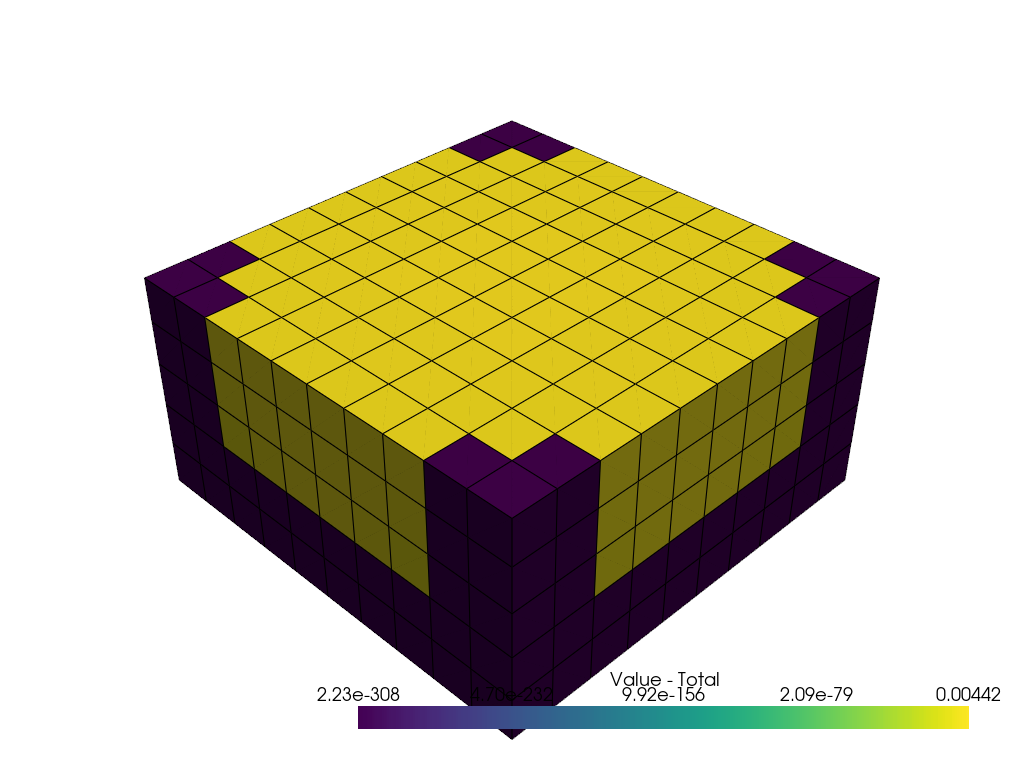

In [ ]:
import pyvista as pv
from pyvista.plotting import Plotter

try:
    pv.start_xvfb()
except OSError:
    # this is needed only on Linux headless servers
    pass

clip = pv_grid.clip(normal='z')

# let's create a pyvista plotter
pv_plotter = Plotter()
pv_plotter.add_mesh(clip, show_edges=True, scalars='Value - Total', log_scale=True)

pv_plotter.show(jupyter_backend='static')

Or maybe a threshold plot to eliminate null values, combined witht the clip

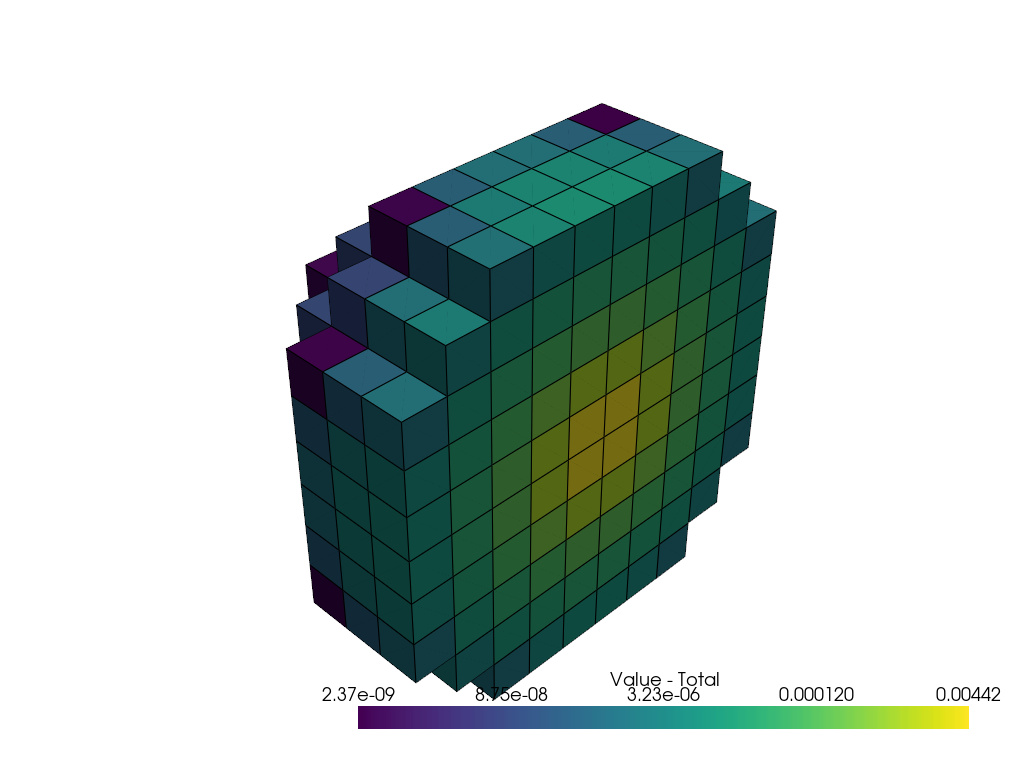

In [47]:
grid = pv_grid.threshold(value=1e-30, scalars='Value - Total').clip(normal='y')

# let's create a pyvista plotter
pv_plotter = Plotter()
pv_plotter.add_mesh(grid, show_edges=True, scalars='Value - Total', log_scale=True)

pv_plotter.show(jupyter_backend='static')

This concludes the F4Enix quick tour. As stated at the very beginning, only a fraction of the capabilities of the library have been shown here and users are strongly recommeneded to familiarize with the more detailed [Examples section](/../examples/examples_idx.html).